In [1]:
# Import necessary libraries
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.nn import sparse_softmax_cross_entropy_with_logits
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, InputLayer, ReLU

%matplotlib inline

Complete the `load_dataset()` function given below :

In [21]:
def load_dataset():
	
	df = pd.read_csv('.\\cifar.csv')

	generator = ImageDataGenerator(rescale=1./255)

	data_gen = generator.flow_from_dataframe(
        df, directory=None, x_col='image', y_col='label',
        target_size=(32,32), color_mode='rgb', seed=30,
        class_mode='categorical', batch_size=50, shuffle=False,
        save_format='png', subset='training'
    )
	    
	return data_gen, df


In [27]:
#Enterr the number of classes
num_classes = 10

# Initialize a sequential model
model = Sequential(name="Occlusion")

# Add the First convolution layer with 32 filters, kernel_size= (3,3), activation='relu', kernel_initializer='he_uniform' & padding='same'
model.add(Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu', kernel_initializer='he_uniform', padding='same'))

# Add the Second convolution layer with 32 filters, kernel_size= (3,3), activation='relu', kernel_initializer='he_uniform' & padding='same'
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))

# Add the First max-pooling layer with pool_size= (2,2)
model.add(MaxPooling2D(pool_size=(2,2)))

# Add the Third convolution layer with 64 filters, kernel_size= (3,3), activation='relu', kernel_initializer='he_uniform' & padding='same'
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))

# Add the Fourth convolution layer with 64 filters, kernel_size= (3,3), activation='relu', kernel_initializer='he_uniform' & padding='same'
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))

# Add the Second max-pooling layer with pool_size= (2,2)
model.add(MaxPooling2D(pool_size=(2,2)))

# Add the Fifth convolution layer with 128 filters, kernel_size= (3,3), activation='relu', kernel_initializer='he_uniform' & padding='same'
model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))

# Add the Sixth convolution layer with 128 filters, kernel_size= (3,3), activation='relu', kernel_initializer='he_uniform' & padding='same'
model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))

# Third max-pooling layer
model.add(MaxPooling2D())

# Flatten layer
model.add(Flatten())

# Fully connected dense layer with 128 neurons, activation='relu' and kernel_initializer='he_uniform'
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compiling the model
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


In [28]:
# Take a quick look at the model summary
model.summary()

Model: "Occlusion"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_39 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                    

In [29]:
# Load the weights of the pre-trained model
model.load_weights('.\\occlusion_model_weights.h5')

In [30]:
#Here is a helper function to apply a grey patch on an image
def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = 127.5
    return patched_image

Complete the `occusion()` function given below :

In [31]:
def occlusion(model, img_num=10, patch_size=4):

	# Load image from the test data
	data_gen, df = load_dataset()
	cifar_dict = { 0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
	 				5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

	num = img_num

	if num>49:
		num=1

	# Get image 
	img = data_gen[0][0][num]

	# Get label
	y_test = data_gen[0][-1]

	# Get the patch size for occlusion
	PATCH_SIZE = patch_size

	# Get the loss of the model with the original image
	loss = model.evaluate(img.reshape(-1,32,32,3), y_test[num].reshape(-1,10), verbose=0)

	# Define a numpy array to store the loss differences
	loss_map = np.zeros((img.shape[0], img.shape[1]))

	# Iterate the patch over the entire image
	for top_left_x in range(0, img.shape[0], PATCH_SIZE):

		for top_left_y in range(0, img.shape[1], PATCH_SIZE):
		  
			# Initialise a new patched image
			patched_image = apply_grey_patch(img, top_left_x, top_left_y, PATCH_SIZE)

			# Get the loss of the model for each patched version
			result = model.evaluate(patched_image.reshape(-1,32,32,3), y_test[num].reshape(-1,10), verbose=0)

			# Get the loss_map of the plot by computing the difference in loss from the original version to the patched value
			loss_map[top_left_y:top_left_y + PATCH_SIZE, top_left_x:top_left_x + PATCH_SIZE] = loss[0] - result[0]


	# Get the predicted label 
	y_prob = model.predict(img.reshape(-1,32,32,3))
	y_pred = cifar_dict[np.argmax(y_prob)]

	# Get true label	
	y_true = cifar_dict[int(np.where(y_test[num]==1)[0])]


	# Plot the original image along with the difference in loss as a heatmap
	fig, ax = plt.subplots(1,2, figsize=(15,15))

	plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
	ax[0].imshow(img)
	ax[1].imshow(img, cmap='gray')
	im = ax[1].imshow(loss_map, cmap='Reds', alpha=0.3)
	fig.colorbar(im,fraction=0.05)
	ax[0].set_title("True Label: "+y_true.upper(), fontsize=15)
	ax[1].set_title("Predicted label with patch size "+str(PATCH_SIZE)+": "+y_pred.upper(), fontsize=15)

Found 50 validated image filenames belonging to 10 classes.
1/1 [==============================] - 0s 299ms/step


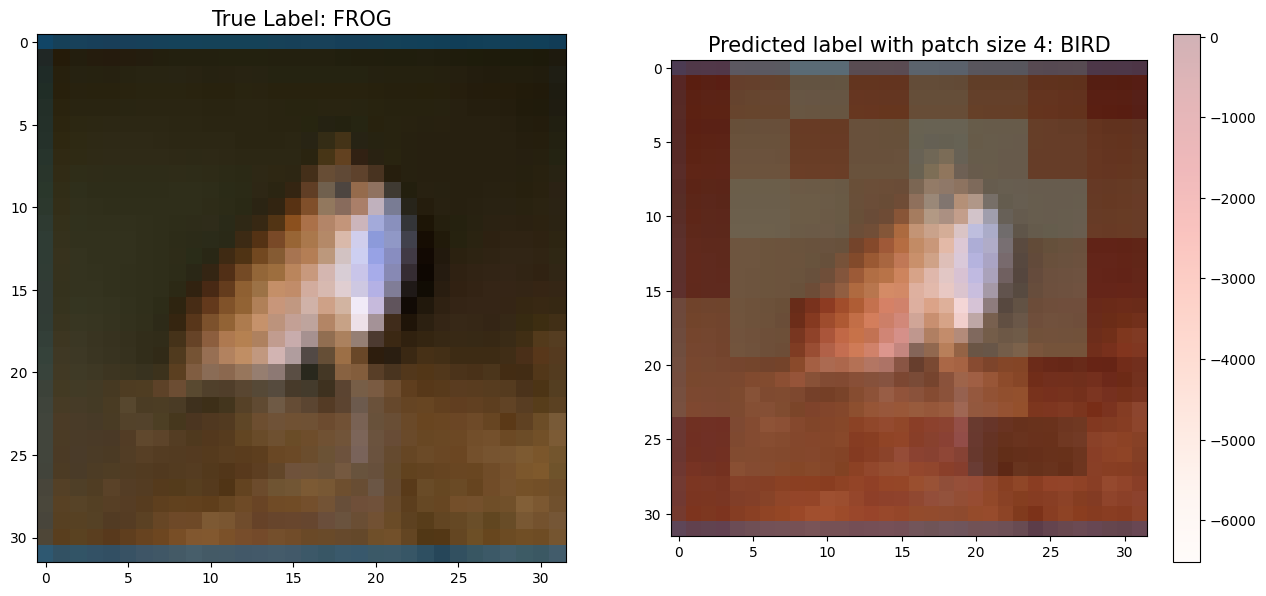

<Figure size 800x600 with 0 Axes>

In [32]:
occlusion(model=model, img_num=10, patch_size=4)

Found 50 validated image filenames belonging to 10 classes.
1/1 [==============================] - 0s 64ms/step


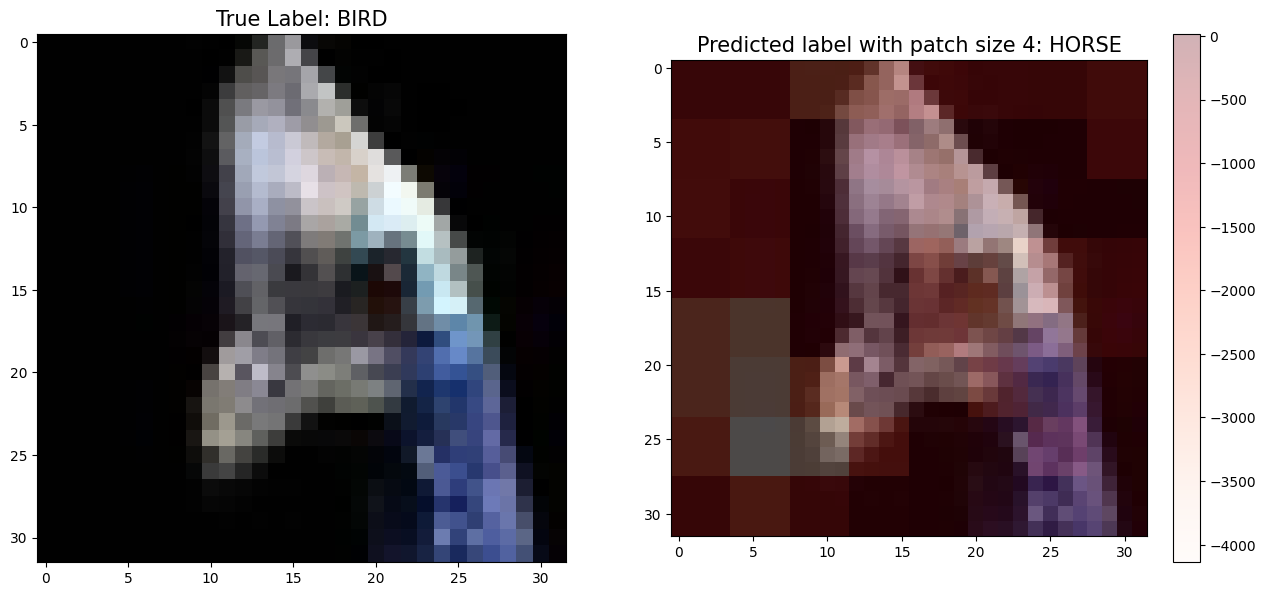

<Figure size 800x600 with 0 Axes>

In [33]:
occlusion(model=model, img_num=12, patch_size=4)

Found 50 validated image filenames belonging to 10 classes.
1/1 [==============================] - 0s 58ms/step


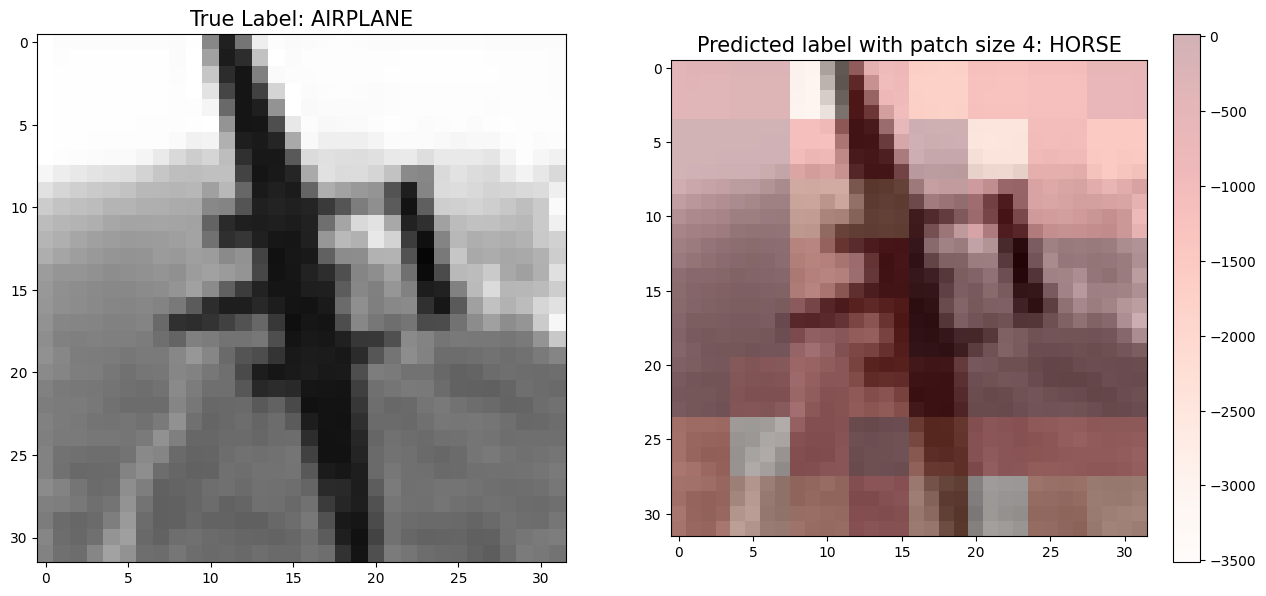

<Figure size 800x600 with 0 Axes>

In [34]:
occlusion(model=model, img_num=35, patch_size=4)

In [ ]:
Answer1 = 'B'

Found 50 validated image filenames belonging to 10 classes.
1/1 [==============================] - 0s 48ms/step
Found 50 validated image filenames belonging to 10 classes.
1/1 [==============================] - 0s 48ms/step
Found 50 validated image filenames belonging to 10 classes.
1/1 [==============================] - 0s 52ms/step


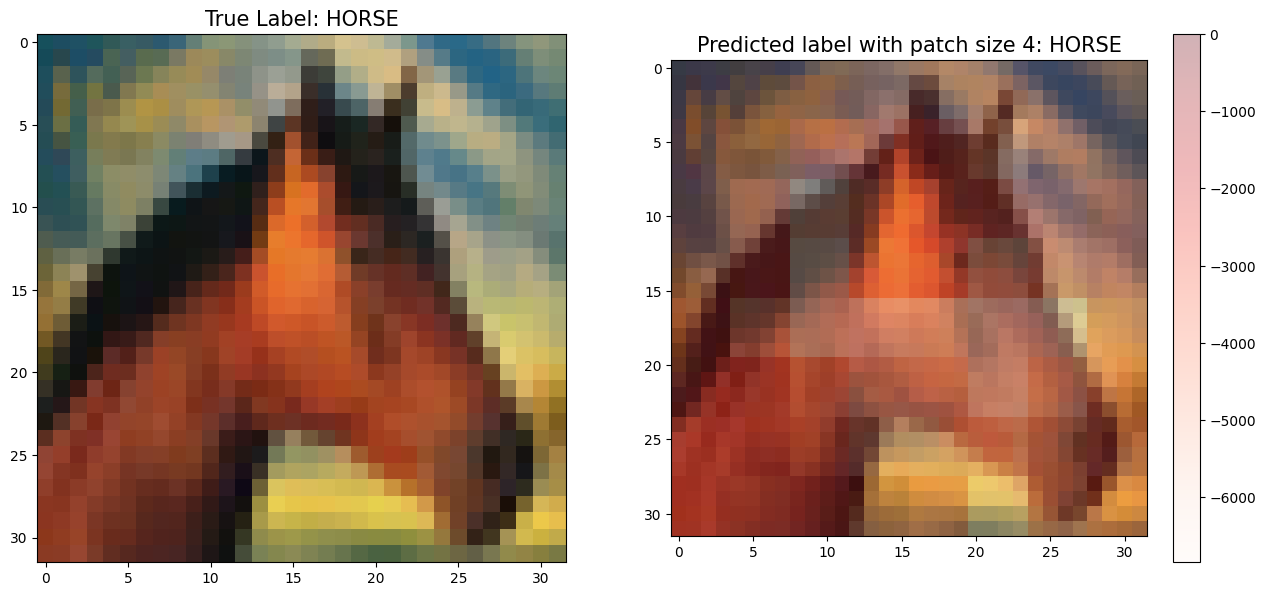

<Figure size 800x600 with 0 Axes>

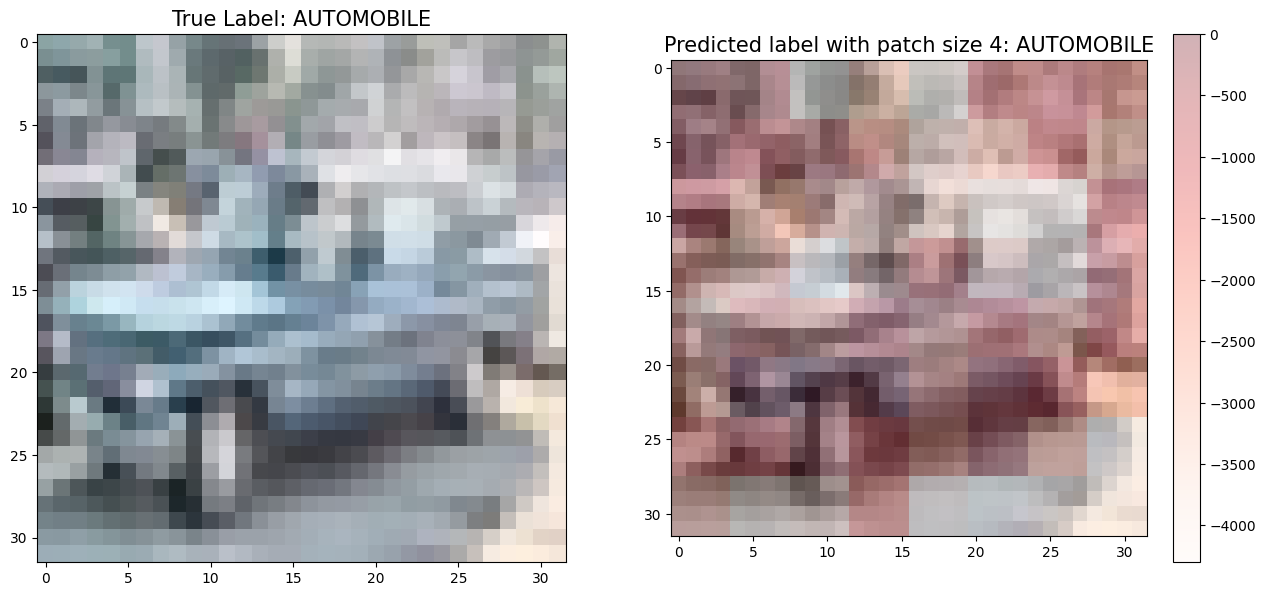

<Figure size 800x600 with 0 Axes>

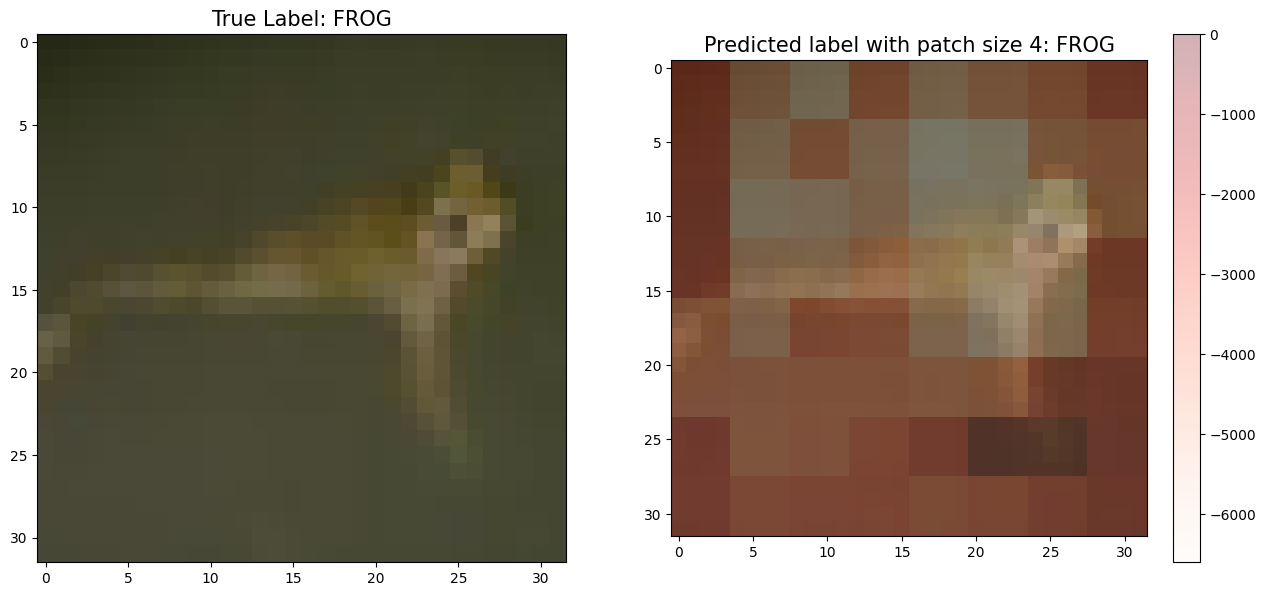

<Figure size 800x600 with 0 Axes>

In [35]:
occlusion(model=model, img_num=1, patch_size=4)
occlusion(model=model, img_num=15, patch_size=4)
occlusion(model=model, img_num=30, patch_size=4)